## CT5141 Optimisation Assignment 2
#### Submitted By: Kalyani Prashant Kawale
#### Student ID: 21237189


**Topic** Facility location with real-valued metaheuristic optimisation. How to run experiments.

**Problem** The **facility location** problem is about finding the best locations for some facilities. In our problem, we have a list of cities, and we are going to build some supermarkets to serve the customers in these cities. The supermarkets could be anywhere, not just at the cities, i.e. a supermarket could be near a city or between two cities. There is no population outside the cities. Supermarkets have no limit on capacity. We want to locate the supermarkets so as to minimise the total travel time for all customers. The objective function is formulated in `supermarket.ipynb` with data in `supermarket_cities_locations.csv` and `supermarket_cities_populations.csv`. A plotting function is included. We will implement a Random Search approach to this problem, a Particle Swarm Optimisation approach, and a CMA approach.


## Solution:

### Code:

> Entry Script defined in last code cell runs the entire experiment

Following packages were installed:

- cma, pyswarms packages are used for implementing optimisation for facility location
- tabulate is being used to display pandas dataframe in the result as a table

#### Uncomment following lines for installing the packages:

In [1]:
# pip install cma
# pip install pyswarms
# pip install tabulate

#### Objective and Plotting Functions (Given):

In [2]:
def total_travel_time(x, c, p):    
    """
    Objective function for Facility Location problem 
    to minimise the distance between each city and supermarket,
    given the population of each city
    :param x: locations of supermarkets (ie genotype), shape eg (5, 2)
    :param c: locations of cities, shape eg (20, 2)
    :param p: populations of cities, shape eg (20,)
    :return: sum of minimum distances
    """
    
    # assume that everyone travels to the supermarket exactly once per
    # week

    # assume that travel time is exactly proportional to Euclidean
    # distance from city to supermarket
    
    # calculate all city-supermarket distances. with (eg) 20 cities
    # and 5 supermarkets, we'll have d.shape = (20, 5)
    d = cdist(c, x)
    # everyone in city i will travel to their nearest supermarket,
    # so we need minimum distance from each city to any supermarket.
    dmin = np.min(d, axis=1)
    # there are p[i] people in city i, each travelling a distance
    # dmin[i], so multiply and sum for total travel time
    return np.sum(dmin * p)


def total_travel_time_slow(x, c, p):
    """
    Slower version of objective function defined above
    :param x: locations of supermarkets (ie genotype), shape eg (5, 2)
    :param c: locations of cities, shape eg (20, 2)
    :param p: populations of cities, shape eg (20,)
    :return: sum of minimum distances
    """
    # Notice that the above is vectorised and is only 2-3 lines. 
    # it's equivalent to this slower (easier to understand?) code
    d = cdist(c, x)
    t = 0
    for i, pi in enumerate(p):
        # everyone in city i will travel to their nearest supermarket,
        # so we need minimum distance from city i to any supermarket.
        d = np.min(D[i])
        # there are pi people in city i, each travelling a distance d
        t += pi * d 
    return t


def plot(x, c, p):
    """
    Method to plot the solution for supermarket facility location optimisation
    A plot showing the locations of the cities and supermarkets is saved under 
    the name supermarket.pdf and displayed in the notebook
    :param x: locations of supermarkets (ie genotype), shape eg (5, 2)
    :param c: locations of cities, shape eg (20, 2)
    :param p: populations of cities, shape eg (20,)
    """
    # solutions will be of shape (eg) (10,)
    # but we interpret as shape (5, 2)
    x = x.reshape((-1, 2))
    plt.figure(figsize=(6, 5))
    plt.scatter(c[:, 0], c[:, 1], s=p/10000, label="Cities") # s gives size
    plt.scatter(x[:, 0], x[:, 1], marker="*", label="Supermarkets") # stars for supermarkets
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.savefig("supermarket.pdf")
    plt.show()
    plt.close()


#### Supplementary methods to calculate and save values of experiements in a data frame named experiment:

In [3]:
def get_min(results):
    """
    Method to get the min/ best solution among the 5 runs of an algorithm
    :param results: list of dictionaries for all solutions and corresponding costs for 5 runs
    :return: dictionary with minimum cost i.e. the best solution
    """
    return min(results, key=lambda item: item['cost'])

def get_mean(results):
    """
    Method to get the mean of costs for the 5 runs of an algorithm
    :param results: list of dictionaries for all solutions and corresponding costs for 5 runs
    :return: mean value of costs rounded into an integer value
    """
    return int(round(np.mean([result['cost'] for result in results])))

def get_stddev(results):
    """
    Method to get the standard deviation of costs for the 5 runs of an algorithm
    :param results: list of dictionaries for all solutions and corresponding costs for 5 runs
    :return: standard deviation value of costs rounded into an integer value
    """
    return int(round(np.std([result['cost'] for result in results])))

def set_record_values(algorithm_name, results, end_time, start_time, popsize=None, w=None, cg=None, cp=None):
    """
    Method to set the values for a single experiment of an algorithm with/without parameters
    :param algorithm_name: name of algorithm of type string
    :param results: list of dictionaries for all solutions and corresponding costs for 5 runs
    :param end_time: list of end times for each run
    :param start_time: list of start times for each run
    :param popsize: integer parameter for population size
    :param w: float parameter for inertia
    :param cg: control parameter for global best
    :param cp: control parameter for local best
    :return: dictionaries with the best result and dataframe entry for an experiment
    """
    best_result = get_min(results)
    record = {"Algorithm": algorithm_name, "popsize": popsize if popsize else "na", "w": w if w else "na", "Φg": cg if cg else "na", "Φp": cp if cp else "na"}
    record["min"] = int(round(best_result['cost']))
    record["min_solution"] = best_result['solution']
    record["mean"] = get_mean(results)
    record["stddev"] = get_stddev(results)
    record["time"] = str(round(np.mean(np.array(end_time) - np.array(start_time)) % 60, 2))+"s"   
    return record

def add_to_table(record):
    """
    Method to add all values for a run of 5 iterations in dataframe
    :param record: dictionary of keys and values for Algorithm name, 
                   all parameters, min, mean, standard deviation and mean elasped time
    """
    global experiment
    experiment = experiment.append(record, ignore_index=True)

#### Random Search:
> Following code was implemented for performing random search with the help of code given in **CT5141 lecture 5 notes** [1]:

In [4]:
def random_search_init(dimension):
    """
    Method to return an initial random solution
    :param dimension: dimension for solution of type integer
    :return numpy array of random values
    """
    return np.array([random.random() for i in range(dimension)])

def random_search_neighbour(x, dimension):
    """
    Method to generate a random mutation of solution
    :param x: list of current solution
    :param dimension: dimension for solution of type integer
    :return numpy array of mutated solution
    """
    x = x.copy()
    i = random.randrange(dimension)
    # add a small constant in range [-delta, delta]
    delta = 0.3
    x[i] += random.random() * 2 * delta - delta
    return x
    
def random_search(init, nbr, f):
    """
    Method to perform random search
    :param init: function for initializing a solution
    :param nbr: neighbour function to create a mutation of current solution
    :param f: objective function
    :return optimised value of cost and corresponding solution
    """
    # generate an initial random solution
    # nsupermarkets * 2: 5 supermarkets represented by longitude and latitude
    x = init(nsupermarkets * 2) 
    # calculating cost for current solution
    fx = f(x.reshape(nsupermarkets, 2), c, p)
    # setting current best cost and solution
    bestx = x
    bestfx = fx    
    # for maxits iterations run random search to get best solution
    for i in range(1, maxits):
        xnew = nbr(x, nsupermarkets * 2) # generate a neighbour of x
        fxnew = f(xnew.reshape((nsupermarkets, 2)), c, p)
        # Minimising the cost
        if fxnew < fx:
            x = xnew
            fx = fxnew
            # Keep track of best solution
            if fxnew < bestfx:
                bestx = x
                bestfx = fx
    # return best solution and cost found by random search
    return bestx, bestfx

def run_random_search():
    """
    Method to run random search for facility location problem 5 times
    """
    print("\nRunning Random Search...")
    # Initialisation of local variables
    rs_results = []
    start_time = []
    end_time = []
    # 5 runs the algorithm with random seeds (0, 1, 2, 3, 4)
    for seed in range(reps):
        random.seed(seed)
        start_time.append(time.time()) # saving start time for the run
        xbest, fbest = random_search(random_search_init, random_search_neighbour, total_travel_time)     
        rs_results.append({'solution': xbest, 'cost': fbest})
        print(f"Run {seed + 1}: {rs_results[seed]}")
        end_time.append(time.time()) # saving end time for the run
        
    # Adding the experiment data to experiment dataframe
    add_to_table(set_record_values("RS", rs_results, end_time, start_time))

#### Covariance Matrix Adaptation (CMA):
> Following code was implemented using **cma python package** [3] and code given in **CT5132 for Fruit Picking example**:

In [5]:
# Covariance Matrix Adaptation
def run_CMA():
    """
    Method to run cma for facility location problem 5 times
    """
    print("\nRunning Covariance Matrix Adaptation...")
    # Initialisation of local variables
    cma_results = []
    start_time = []
    end_time = []    
    sigma = 0.5
    # 5 runs the algorithm with random seeds (1, 2, 3, 4, 5)
    for seed in range(1, reps+1):
        np.random.seed(seed)
        start_time.append(time.time()) # saving start time for the run
        initial = np.random.random(nsupermarkets * 2) # initial x, y locations of supermarkets
        # setting CMAEvolutionStrategy with initial values of x and sigma
        es = cma.CMAEvolutionStrategy(initial, sigma, {'seed':seed})
        i = 0
        # finding the optimised solution by ask and tell method of cma package
        while not es.stop() and i < maxits / es.popsize:
            X = es.ask()
            current_x = X[0]        
            es.tell(X, [total_travel_time(x.reshape((nsupermarkets, 2)), c, p) for x in X])     
            i += 1
        xbest, fbest, evals_best, evaluations, iterations, xfavorite, stds, stop = es.result # fetching best solution and cost
        cma_results.append({'solution': xbest, 'cost': fbest})
        print(f"Run {seed}: {cma_results[seed - 1]}")
        end_time.append(time.time()) # saving end time for the run
    
    # Adding the experiment data to experiment dataframe
    add_to_table(set_record_values("CMA", cma_results, end_time, start_time))

#### Particle Swarm Optimisation (PSO):
> Following code was implemented using **pyswarms python package** [6]:

In [6]:
# Particle Swarm Optimisation
def f(x):
    """
    Method to get values from objective function for passing them to be minimised by GlobalBestPSO of pyswarms
    :param x: list of lists of solutions of the size of the swarm
    :return: numpy array containing cost values for all solutions
    """
    n_particles = x.shape[0]
    j = [total_travel_time(x[i].reshape(nsupermarkets, 2), c, p) for i in range(n_particles)]
    return np.array(j)

def run_PSO():
    """
    Method to run PSO for facility location problem 5 times
    """
    print("\nRunning Particle Swarm Optimisation...")
    ## parameter popsize: 
    # the population sizes 10 and 100 have been selected 
    # to check the behaviour of PSO for swarm size equal to dimension of solution 
    # and a much larger value compared to the dimension of the solution
    popsizes = [10, 100]
    ## control parameter for local best:
    # a small value of 0.5 decreases the significance of local best
    # a large value of 2 increses the significance of local best
    cp_s = [0.5, 2]
    ## control parameter for global best:
    # a small value of 0.5 decreases the significance of global best 
    # i.e. it decreases the movement of particles towards global best 
    # a large value of 2 increses the significance of global best
    # i.e. it speeds the movement of particles towards global best 
    cg_s = [0.5, 2]
    ## parameter inertia:
    # 0.4 has been selected to make the PSO more exploitative by increasing the significance of pbest and gbest
    # 0.9 has been selected to make the PSO more explorative by decreasing the significance of pbest and gbest
    w_s = [0.4, 0.9]

    # running factorial experiment for all values of popsize, w, cp and cg parameters
    for popsize, cp, cg, w in itertools.product(popsizes, cp_s, cg_s, w_s):
        # Initialisation of local variables
        options = {'c1': cp, 'c2': cg, 'w': w}        
        pso_results = []
        start_time = []
        end_time = []
        # 5 runs the algorithm with random seeds (0, 1, 2, 3, 4)
        for seed in range(reps):            
            random.seed(seed)
            start_time.append(time.time()) # saving start time for the run
            # Call instance of PSO
            optimizer = ps.single.GlobalBestPSO(n_particles=popsize, dimensions=nsupermarkets * 2, options=options)
            # Perform optimization
            best_cost, best_position = optimizer.optimize(f, iters=int(maxits/popsize))
            pso_results.append({'solution': best_position, 'cost': best_cost})
            print(f"Run {seed + 1}: {pso_results[seed - 1]}")
            end_time.append(time.time()) # saving end time for the run
            
        # Adding the experiment data to experiment dataframe
        add_to_table(set_record_values("PSO", pso_results, end_time, start_time, popsize=popsize, w=w, cg=cg, cp=cp))


#### Method for displaying results:

In [7]:
def display_results():
    """
    Method to display experiment table, get and plot the overall best solution
    """
    experiment_display = experiment.drop('min_solution', axis=1)    
    print("\nResults:")
    print(experiment_display.to_markdown()) # displaying the experiment results
    
    best = experiment.query(f"min=={min(experiment['min'])}") # finding the experiment with minimum cost (overall best)
    global_best_solution = np.array(best['min_solution'].item()) # fetching best solution
    global_best_cost = best['min'].item() # fetching best cost
    print(f"\nOverall Best Solution:{global_best_solution}")
    print(f"Overall Minimum Cost:{global_best_cost}")
        
    print("\nPlot for Best Solution for Supermarket Facility Location:")
    plot(global_best_solution, c, p) # plotting the best solution ever found

### Entry Script:
>Running following script will run the whole experiment and display the results, provided all function definitions are in the memory:


Running Random Search...
Run 1: {'solution': array([0.80981494, 0.7691395 , 0.08617055, 0.39397015, 0.64830569,
       0.40214396, 0.54296779, 0.52912585, 0.12071491, 0.65464181]), 'cost': 172664.15405052545}
Run 2: {'solution': array([0.12118777, 0.65508017, 0.88245855, 0.98901285, 0.64831851,
       0.40240552, 0.80975016, 0.76813214, 0.08638312, 0.39349119]), 'cost': 216944.1193886348}
Run 3: {'solution': array([0.88259541, 0.98928764, 0.0862402 , 0.39380765, 0.80950575,
       0.7677227 , 0.64830069, 0.40240308, 0.54244892, 0.52961998]), 'cost': 151121.9179736905}
Run 4: {'solution': array([0.54252062, 0.52935116, 0.80939792, 0.76842928, 0.64846203,
       0.40244664, 0.12075693, 0.65501308, 0.08619846, 0.39405593]), 'cost': 171992.52663512476}
Run 5: {'solution': array([0.08667134, 0.39319672, 0.64793434, 0.40261349, 0.12080929,
       0.6546411 , 0.81007049, 0.76877626, 0.66178522, 0.13104032]), 'cost': 279075.4262113614}

Running Covariance Matrix Adaptation...
(5_w,10)-aCMA-ES

2021-11-17 23:49:41,984 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   4%|██▌                                                       |87/2000, best_cost=3.39e+5

NOTE (module=cma, iteration=649):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.7e+08 to 2.6e+01
Run 5: {'solution': array([0.80954198, 0.76829616, 0.64831793, 0.4023767 , 0.12073474,
       0.65456506, 1.90592311, 1.40251826, 0.08617522, 0.39393245]), 'cost': 296348.5518481608}

Running Particle Swarm Optimisation...


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=3.27e+5
2021-11-17 23:49:44,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 326706.21278807987, best pos: [0.64812549 0.40238971 0.76303132 0.68911231 0.81019178 0.76855923
 0.19188814 0.72424078 0.26752141 0.27407349]
2021-11-17 23:49:44,340 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   5%|██▋                                                       |94/2000, best_cost=2.73e+5

Run 1: {'solution': array([0.64812549, 0.40238971, 0.76303132, 0.68911231, 0.81019178,
       0.76855923, 0.19188814, 0.72424078, 0.26752141, 0.27407349]), 'cost': 326706.21278807987}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.73e+5
2021-11-17 23:49:46,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 273454.8323427777, best pos: [0.64833881 0.40238122 0.82314678 0.7702223  0.26917555 0.58100848
 0.90642787 0.95045388 0.57464419 0.6103222 ]
2021-11-17 23:49:46,593 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   5%|██▊                                                        |94/2000, best_cost=4.6e+5

Run 2: {'solution': array([0.64812549, 0.40238971, 0.76303132, 0.68911231, 0.81019178,
       0.76855923, 0.19188814, 0.72424078, 0.26752141, 0.27407349]), 'cost': 326706.21278807987}


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████|2000/2000, best_cost=4.6e+5
2021-11-17 23:49:48,887 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 459999.8797659141, best pos: [0.64844012 0.40238238 0.32777016 0.96034794 1.04383677 0.29542714
 0.80583626 0.76631202 0.59274543 0.8459526 ]
2021-11-17 23:49:48,895 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   5%|██▋                                                       |93/2000, best_cost=3.37e+5

Run 3: {'solution': array([0.64833881, 0.40238122, 0.82314678, 0.7702223 , 0.26917555,
       0.58100848, 0.90642787, 0.95045388, 0.57464419, 0.6103222 ]), 'cost': 273454.8323427777}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=3.37e+5
2021-11-17 23:49:52,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 337406.832644343, best pos: [0.64926778 0.40218712 0.81081755 0.76659149 0.50639205 0.51240246
 0.60701213 0.60455294 0.79928544 1.07206925]
2021-11-17 23:49:52,180 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   3%|█▋                                                        |58/2000, best_cost=4.15e+5

Run 4: {'solution': array([0.64844012, 0.40238238, 0.32777016, 0.96034794, 1.04383677,
       0.29542714, 0.80583626, 0.76631202, 0.59274543, 0.8459526 ]), 'cost': 459999.8797659141}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=4.15e+5
2021-11-17 23:49:55,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 415253.9762444826, best pos: [0.58215974 0.52922579 0.65004146 0.40365079 0.82207667 0.90750179
 0.49441587 0.92694567 0.88205217 0.82469174]
2021-11-17 23:49:55,629 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |61/2000, best_cost=3.52e+5

Run 5: {'solution': array([0.64926778, 0.40218712, 0.81081755, 0.76659149, 0.50639205,
       0.51240246, 0.60701213, 0.60455294, 0.79928544, 1.07206925]), 'cost': 337406.832644343}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.72e+5
2021-11-17 23:49:59,060 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 272324.4819476356, best pos: [0.88256928 0.98920928 0.80954731 0.76829758 0.61369989 1.01727197
 0.64839058 0.40239142 0.09048302 0.44742161]
2021-11-17 23:49:59,074 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▉                                                         |65/2000, best_cost=2.7e+5

Run 1: {'solution': array([0.88256928, 0.98920928, 0.80954731, 0.76829758, 0.61369989,
       1.01727197, 0.64839058, 0.40239142, 0.09048302, 0.44742161]), 'cost': 272324.4819476356}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.28e+5
2021-11-17 23:50:02,520 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 228214.7160372256, best pos: [0.88256455 0.98799764 0.21606327 0.72073777 0.64831793 0.4023767
 0.08638415 0.39383253 0.80954198 0.76829616]
2021-11-17 23:50:02,531 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▌                                                        |53/2000, best_cost=3.81e+5

Run 2: {'solution': array([0.88256928, 0.98920928, 0.80954731, 0.76829758, 0.61369989,
       1.01727197, 0.64839058, 0.40239142, 0.09048302, 0.44742161]), 'cost': 272324.4819476356}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.81e+5
2021-11-17 23:50:06,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 280564.78336471994, best pos: [0.09842145 0.38796798 0.12073387 0.6545657  0.80954198 0.76829616
 0.64831793 0.4023767  0.66113276 0.10955342]
2021-11-17 23:50:06,092 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |63/2000, best_cost=3.19e+5

Run 3: {'solution': array([0.88256455, 0.98799764, 0.21606327, 0.72073777, 0.64831793,
       0.4023767 , 0.08638415, 0.39383253, 0.80954198, 0.76829616]), 'cost': 228214.7160372256}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.97e+5
2021-11-17 23:50:09,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 296723.0070688592, best pos: [0.1518522  0.94700237 0.64831585 0.40238776 0.18369736 0.06737957
 0.80954199 0.76829629 0.08617523 0.39393246]
2021-11-17 23:50:09,554 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |61/2000, best_cost=2.66e+5

Run 4: {'solution': array([0.09842145, 0.38796798, 0.12073387, 0.6545657 , 0.80954198,
       0.76829616, 0.64831793, 0.4023767 , 0.66113276, 0.10955342]), 'cost': 280564.78336471994}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.32e+5
2021-11-17 23:50:12,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 231672.8659577534, best pos: [0.11362402 0.48317696 0.5426462  0.52977381 0.9164906  0.55182697
 0.64831793 0.4023767  0.81226728 0.76950656]
2021-11-17 23:50:12,996 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                        |61/2000, best_cost=3.21e+5

Run 5: {'solution': array([0.1518522 , 0.94700237, 0.64831585, 0.40238776, 0.18369736,
       0.06737957, 0.80954199, 0.76829629, 0.08617523, 0.39393246]), 'cost': 296723.0070688592}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=3.06e+5
2021-11-17 23:50:16,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 305966.24308216095, best pos: [-0.28068378  0.3649388   0.39731851  0.9715762   0.80958098  0.76832914
  0.54259954  0.52989753  0.64831794  0.40238147]
2021-11-17 23:50:16,410 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                         |61/2000, best_cost=3.4e+5

Run 1: {'solution': array([-0.28068378,  0.3649388 ,  0.39731851,  0.9715762 ,  0.80958098,
        0.76832914,  0.54259954,  0.52989753,  0.64831794,  0.40238147]), 'cost': 305966.24308216095}


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████|2000/2000, best_cost=3.4e+5
2021-11-17 23:50:19,862 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 340095.6379938703, best pos: [0.72799983 0.58917812 0.35222702 0.26821214 0.80951892 0.76830265
 0.64831767 0.40237804 0.13530469 0.78388302]
2021-11-17 23:50:19,871 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▉                                                        |68/2000, best_cost=2.33e+5

Run 2: {'solution': array([-0.28068378,  0.3649388 ,  0.39731851,  0.9715762 ,  0.80958098,
        0.76832914,  0.54259954,  0.52989753,  0.64831794,  0.40238147]), 'cost': 305966.24308216095}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.33e+5
2021-11-17 23:50:23,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 233413.07916994934, best pos: [0.22661968 0.54944383 0.5425991  0.52992557 0.80958912 0.7683151
 0.64801222 0.40227896 0.69275158 0.12979206]
2021-11-17 23:50:23,267 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▉                                                        |66/2000, best_cost=3.78e+5

Run 3: {'solution': array([0.72799983, 0.58917812, 0.35222702, 0.26821214, 0.80951892,
       0.76830265, 0.64831767, 0.40237804, 0.13530469, 0.78388302]), 'cost': 340095.6379938703}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=3.78e+5
2021-11-17 23:50:26,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 377986.57544285414, best pos: [ 0.12059077  0.65439117  0.38931913  0.02493067  0.64831592  0.40236608
  0.81279827  0.72956703 -0.24908328  0.82743375]
2021-11-17 23:50:26,590 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                        |61/2000, best_cost=2.93e+5

Run 4: {'solution': array([0.22661968, 0.54944383, 0.5425991 , 0.52992557, 0.80958912,
       0.7683151 , 0.64801222, 0.40227896, 0.69275158, 0.12979206]), 'cost': 233413.07916994934}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.92e+5
2021-11-17 23:50:29,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 292145.45229283324, best pos: [0.12119929 0.65489306 0.25869832 0.14897782 0.09650069 0.28659651
 0.64831725 0.40237684 0.8096265  0.76913646]
2021-11-17 23:50:29,985 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |62/2000, best_cost=7.13e+5

Run 5: {'solution': array([ 0.12059077,  0.65439117,  0.38931913,  0.02493067,  0.64831592,
        0.40236608,  0.81279827,  0.72956703, -0.24908328,  0.82743375]), 'cost': 377986.57544285414}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=7.13e+5
2021-11-17 23:50:33,336 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 713158.496359525, best pos: [ 0.80371446  0.95445105  1.10882729  1.11204248  0.5987737   0.58827859
 -0.4195353  -0.12075427  0.69806517  0.36485295]
2021-11-17 23:50:33,349 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▉                                                        |65/2000, best_cost=4.98e+5

Run 1: {'solution': array([ 0.80371446,  0.95445105,  1.10882729,  1.11204248,  0.5987737 ,
        0.58827859, -0.4195353 , -0.12075427,  0.69806517,  0.36485295]), 'cost': 713158.496359525}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=4.98e+5
2021-11-17 23:50:36,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 497864.36290147976, best pos: [0.87808726 0.71614106 0.30128978 0.33650862 0.63116687 0.42311005
 1.20117886 0.56892358 0.73037192 0.98285686]
2021-11-17 23:50:36,740 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |64/2000, best_cost=6.57e+5

Run 2: {'solution': array([ 0.80371446,  0.95445105,  1.10882729,  1.11204248,  0.5987737 ,
        0.58827859, -0.4195353 , -0.12075427,  0.69806517,  0.36485295]), 'cost': 713158.496359525}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=5.32e+5
2021-11-17 23:50:40,101 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 531873.6857119206, best pos: [-9.93258028e+02  5.88895396e-01  9.52258272e-01 -5.59969915e+03
  6.57554840e-01  4.46838561e-01  8.77820805e-01  7.49509459e-01
  6.16199698e-02  4.85102456e-01]
2021-11-17 23:50:40,110 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   2%|█▍                                                         |49/2000, best_cost=6.5e+5

Run 3: {'solution': array([0.87808726, 0.71614106, 0.30128978, 0.33650862, 0.63116687,
       0.42311005, 1.20117886, 0.56892358, 0.73037192, 0.98285686]), 'cost': 497864.36290147976}


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████|2000/2000, best_cost=6.5e+5
2021-11-17 23:50:43,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 650204.797554124, best pos: [ 0.77296787  0.86555005  0.41780969  1.90922485  0.62073557  0.38151127
  0.34854676  1.24414062  0.3256018  -1.46926012]
2021-11-17 23:50:43,468 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▉                                                        |68/2000, best_cost=6.92e+5

Run 4: {'solution': array([-9.93258028e+02,  5.88895396e-01,  9.52258272e-01, -5.59969915e+03,
        6.57554840e-01,  4.46838561e-01,  8.77820805e-01,  7.49509459e-01,
        6.16199698e-02,  4.85102456e-01]), 'cost': 531873.6857119206}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=6.92e+5
2021-11-17 23:50:46,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 692085.4527276886, best pos: [ 0.87073122  0.84449684 -0.00899584  0.88692165  0.70680395  0.47748855
  0.17712112  0.08189589  0.05560147  0.08372312]
2021-11-17 23:50:46,775 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                         |63/2000, best_cost=3.7e+5

Run 5: {'solution': array([ 0.77296787,  0.86555005,  0.41780969,  1.90922485,  0.62073557,
        0.38151127,  0.34854676,  1.24414062,  0.3256018 , -1.46926012]), 'cost': 650204.797554124}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.68e+5
2021-11-17 23:50:50,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 267829.60066590155, best pos: [0.80787658 0.771833   0.36635132 0.53553459 0.64899713 0.40220398
 0.5819156  0.46969148 0.88216962 0.98903621]
2021-11-17 23:50:50,125 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   3%|█▉                                                        |66/2000, best_cost=2.67e+5

Run 1: {'solution': array([0.80787658, 0.771833  , 0.36635132, 0.53553459, 0.64899713,
       0.40220398, 0.5819156 , 0.46969148, 0.88216962, 0.98903621]), 'cost': 267829.60066590155}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.47e+5
2021-11-17 23:50:53,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 247012.57299213327, best pos: [0.81026157 0.76824419 0.6478233  0.40006472 0.53641239 0.51201822
 0.16634764 0.65310075 0.49785641 0.31634328]
2021-11-17 23:50:53,447 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                        |61/2000, best_cost=3.44e+5

Run 2: {'solution': array([0.80787658, 0.771833  , 0.36635132, 0.53553459, 0.64899713,
       0.40220398, 0.5819156 , 0.46969148, 0.88216962, 0.98903621]), 'cost': 267829.60066590155}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=3.28e+5
2021-11-17 23:50:56,761 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 327505.295382452, best pos: [0.79893347 0.77306084 0.67381239 0.40235191 0.38704236 1.0657483
 0.28516133 0.40276634 0.54749837 0.52472457]
2021-11-17 23:50:56,778 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   3%|█▌                                                         |55/2000, best_cost=2.8e+5

Run 3: {'solution': array([0.81026157, 0.76824419, 0.6478233 , 0.40006472, 0.53641239,
       0.51201822, 0.16634764, 0.65310075, 0.49785641, 0.31634328]), 'cost': 247012.57299213327}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.53e+5
2021-11-17 23:51:00,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 253119.53814257283, best pos: [0.64824356 0.40250863 0.56772769 0.52949757 0.18230926 0.71923044
 0.45349404 0.1179062  0.80472298 0.77594104]
2021-11-17 23:51:00,098 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:   2%|█▍                                                        |49/2000, best_cost=3.51e+5

Run 4: {'solution': array([0.79893347, 0.77306084, 0.67381239, 0.40235191, 0.38704236,
       1.0657483 , 0.28516133, 0.40276634, 0.54749837, 0.52472457]), 'cost': 327505.295382452}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=1.93e+5
2021-11-17 23:51:03,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 192979.244499693, best pos: [0.64800572 0.40104405 0.80819402 0.76733906 0.54281046 0.53168757
 0.14158473 0.48747569 0.8104334  0.92976767]
2021-11-17 23:51:03,453 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▍                                                        |51/2000, best_cost=6.32e+5

Run 5: {'solution': array([0.64824356, 0.40250863, 0.56772769, 0.52949757, 0.18230926,
       0.71923044, 0.45349404, 0.1179062 , 0.80472298, 0.77594104]), 'cost': 253119.53814257283}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=6.18e+5
2021-11-17 23:51:06,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 618383.8136804943, best pos: [ 9.07737952e-01  9.20138425e-01  4.13948170e-01  7.30930618e-01
  9.89774989e+01 -2.61618426e+00  6.74974101e-01  4.41098887e-01
 -6.94623931e-02  1.51139465e-01]
2021-11-17 23:51:06,821 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   2%|█▎                                                        |47/2000, best_cost=5.85e+5

Run 1: {'solution': array([ 9.07737952e-01,  9.20138425e-01,  4.13948170e-01,  7.30930618e-01,
        9.89774989e+01, -2.61618426e+00,  6.74974101e-01,  4.41098887e-01,
       -6.94623931e-02,  1.51139465e-01]), 'cost': 618383.8136804943}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=5.85e+5
2021-11-17 23:51:10,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 584843.8554732166, best pos: [-0.30074981  0.58328892  0.12792085 -0.00978534  3.75199586 -1.04367783
  0.65046326  0.39629382  0.69681575  0.8702482 ]
2021-11-17 23:51:10,189 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▌                                                        |56/2000, best_cost=4.68e+5

Run 2: {'solution': array([ 9.07737952e-01,  9.20138425e-01,  4.13948170e-01,  7.30930618e-01,
        9.89774989e+01, -2.61618426e+00,  6.74974101e-01,  4.41098887e-01,
       -6.94623931e-02,  1.51139465e-01]), 'cost': 618383.8136804943}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=4.65e+5
2021-11-17 23:51:13,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 465102.9656289915, best pos: [0.02229684 0.44067825 0.62177982 0.42352576 1.00056507 1.06276393
 0.74384378 0.8017574  3.43209111 2.3568675 ]
2021-11-17 23:51:13,498 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |64/2000, best_cost=6.26e+5

Run 3: {'solution': array([-0.30074981,  0.58328892,  0.12792085, -0.00978534,  3.75199586,
       -1.04367783,  0.65046326,  0.39629382,  0.69681575,  0.8702482 ]), 'cost': 584843.8554732166}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=5.73e+5
2021-11-17 23:51:16,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 573049.0062658173, best pos: [  -6.29839148  -10.38019808    1.49487721    4.39941416    0.64123717
    0.41912798    0.81985693    0.77926333 -231.1709202    30.00691938]
2021-11-17 23:51:16,844 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   3%|█▉                                                        |65/2000, best_cost=5.44e+5

Run 4: {'solution': array([0.02229684, 0.44067825, 0.62177982, 0.42352576, 1.00056507,
       1.06276393, 0.74384378, 0.8017574 , 3.43209111, 2.3568675 ]), 'cost': 465102.9656289915}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=5.44e+5
2021-11-17 23:51:20,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 544230.5918721892, best pos: [ 0.97996073  0.97302112  0.07459217  0.4893959   0.76380242  0.71934152
  0.64082452  0.48087741 -0.294582    0.21059457]
2021-11-17 23:51:20,275 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▉                                                        |67/2000, best_cost=2.56e+5

Run 5: {'solution': array([  -6.29839148,  -10.38019808,    1.49487721,    4.39941416,
          0.64123717,    0.41912798,    0.81985693,    0.77926333,
       -231.1709202 ,   30.00691938]), 'cost': 573049.0062658173}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.32e+5
2021-11-17 23:51:23,650 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 231560.07961576022, best pos: [  0.5425991    0.52992577   0.10732129   0.41277715   0.80954198
   0.76829616   0.75288849 -15.40175906   0.64831793   0.4023767 ]
2021-11-17 23:51:23,662 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                        |62/2000, best_cost=2.23e+5

Run 1: {'solution': array([  0.5425991 ,   0.52992577,   0.10732129,   0.41277715,
         0.80954198,   0.76829616,   0.75288849, -15.40175906,
         0.64831793,   0.4023767 ]), 'cost': 231560.07961576022}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.17e+5
2021-11-17 23:51:27,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 216511.44128219233, best pos: [0.88256804 0.98920928 0.80954198 0.76829616 0.08617523 0.39393245
 0.12082215 0.65462688 0.64831793 0.4023767 ]
2021-11-17 23:51:27,105 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|██                                                         |69/2000, best_cost=2.3e+5

Run 2: {'solution': array([  0.5425991 ,   0.52992577,   0.10732129,   0.41277715,
         0.80954198,   0.76829616,   0.75288849, -15.40175906,
         0.64831793,   0.4023767 ]), 'cost': 231560.07961576022}


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████|2000/2000, best_cost=2.3e+5
2021-11-17 23:51:30,481 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 230131.00281844527, best pos: [1.55900594 0.33785538 0.64831793 0.4023767  0.5425991  0.52992577
 0.08617522 0.39393245 0.80954198 0.76829616]
2021-11-17 23:51:30,498 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                         |63/2000, best_cost=2.8e+5

Run 3: {'solution': array([0.88256804, 0.98920928, 0.80954198, 0.76829616, 0.08617523,
       0.39393245, 0.12082215, 0.65462688, 0.64831793, 0.4023767 ]), 'cost': 216511.44128219233}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=2.78e+5
2021-11-17 23:51:33,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 277709.10013713455, best pos: [0.08627384 0.3938852  0.12073485 0.6545662  0.80954198 0.76829616
 0.66190807 0.13111017 0.64831793 0.4023767 ]
2021-11-17 23:51:33,870 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:   3%|█▊                                                        |63/2000, best_cost=1.89e+5

Run 4: {'solution': array([1.55900594, 0.33785538, 0.64831793, 0.4023767 , 0.5425991 ,
       0.52992577, 0.08617522, 0.39393245, 0.80954198, 0.76829616]), 'cost': 230131.00281844527}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=1.71e+5
2021-11-17 23:51:37,286 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 170930.51404950517, best pos: [0.80954199 0.76829618 0.12073475 0.65456507 0.5425991  0.52992574
 0.08617523 0.39393244 0.64831793 0.4023767 ]
2021-11-17 23:51:37,302 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |62/2000, best_cost=6.74e+5

Run 5: {'solution': array([0.08627384, 0.3938852 , 0.12073485, 0.6545662 , 0.80954198,
       0.76829616, 0.66190807, 0.13111017, 0.64831793, 0.4023767 ]), 'cost': 277709.10013713455}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=6.74e+5
2021-11-17 23:51:40,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 673900.1400577822, best pos: [0.91342477 0.75552479 0.71176366 0.45600137 0.51663568 0.45347571
 0.21012829 0.04485044 0.08099013 0.1314892 ]
2021-11-17 23:51:40,682 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▉                                                        |65/2000, best_cost=6.46e+5

Run 1: {'solution': array([0.91342477, 0.75552479, 0.71176366, 0.45600137, 0.51663568,
       0.45347571, 0.21012829, 0.04485044, 0.08099013, 0.1314892 ]), 'cost': 673900.1400577822}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=6.46e+5
2021-11-17 23:51:44,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 645706.7076735961, best pos: [ 1.90188517  0.31567775  0.01464345  1.21384338  0.83746425  0.87640721
  0.11197104 -1.11285561  0.60006083  0.42153443]
2021-11-17 23:51:44,066 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▉                                                        |68/2000, best_cost=5.88e+5

Run 2: {'solution': array([0.91342477, 0.75552479, 0.71176366, 0.45600137, 0.51663568,
       0.45347571, 0.21012829, 0.04485044, 0.08099013, 0.1314892 ]), 'cost': 673900.1400577822}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=5.88e+5
2021-11-17 23:51:47,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 588276.6444864059, best pos: [0.80534959 0.81145307 0.65777736 0.38043987 0.94011461 0.96019063
 0.87383922 0.89206509 0.77028216 0.68006985]
2021-11-17 23:51:47,467 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |63/2000, best_cost=7.55e+5

Run 3: {'solution': array([ 1.90188517,  0.31567775,  0.01464345,  1.21384338,  0.83746425,
        0.87640721,  0.11197104, -1.11285561,  0.60006083,  0.42153443]), 'cost': 645706.7076735961}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=7.55e+5
2021-11-17 23:51:50,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 755427.1245290916, best pos: [0.39383768 0.64613408 0.32207452 0.86506011 0.77038492 0.45916001
 0.65827276 0.42405388 0.54884294 0.96392608]
2021-11-17 23:51:50,825 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   3%|█▊                                                        |64/2000, best_cost=5.99e+5

Run 4: {'solution': array([0.80534959, 0.81145307, 0.65777736, 0.38043987, 0.94011461,
       0.96019063, 0.87383922, 0.89206509, 0.77028216, 0.68006985]), 'cost': 588276.6444864059}


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|2000/2000, best_cost=5.99e+5
2021-11-17 23:51:54,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 598843.6270999282, best pos: [ 0.5991645   0.0214477   0.78757805  0.90503526 -0.07579411  0.39666803
  0.60790894  0.45692008 -0.70212999  5.25408858]
2021-11-17 23:51:54,180 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  12%|██████▊                                                    |23/200, best_cost=3.19e+5

Run 5: {'solution': array([0.39383768, 0.64613408, 0.32207452, 0.86506011, 0.77038492,
       0.45916001, 0.65827276, 0.42405388, 0.54884294, 0.96392608]), 'cost': 755427.1245290916}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.15e+5
2021-11-17 23:51:55,153 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 314792.574124433, best pos: [0.79224344 0.98711825 0.5418361  0.52383363 0.64832776 0.40238009
 0.80976634 0.76821556 1.04424696 0.71941875]
2021-11-17 23:51:55,162 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=3.65e+5

Run 1: {'solution': array([0.79224344, 0.98711825, 0.5418361 , 0.52383363, 0.64832776,
       0.40238009, 0.80976634, 0.76821556, 1.04424696, 0.71941875]), 'cost': 314792.574124433}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.63e+5
2021-11-17 23:51:56,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 363106.45461649157, best pos: [0.88847534 0.57148221 0.52214967 0.52447193 0.64832891 0.40237079
 0.97121208 0.28992157 0.80988373 0.76886615]
2021-11-17 23:51:56,150 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=2.52e+5

Run 2: {'solution': array([0.79224344, 0.98711825, 0.5418361 , 0.52383363, 0.64832776,
       0.40238009, 0.80976634, 0.76821556, 1.04424696, 0.71941875]), 'cost': 314792.574124433}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.49e+5
2021-11-17 23:51:57,153 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 248561.54054072202, best pos: [0.11330338 0.56356544 0.83441969 0.78406093 0.5426152  0.52973944
 0.67788857 0.76820772 0.6483286  0.40237579]
2021-11-17 23:51:57,161 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=3.36e+5

Run 3: {'solution': array([0.88847534, 0.57148221, 0.52214967, 0.52447193, 0.64832891,
       0.40237079, 0.97121208, 0.28992157, 0.80988373, 0.76886615]), 'cost': 363106.45461649157}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.25e+5
2021-11-17 23:51:58,146 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 324746.6262960794, best pos: [0.78440152 0.92927293 0.80968081 0.76930882 0.97006442 0.3816748
 0.64833575 0.40235991 0.53065107 0.53681224]
2021-11-17 23:51:58,154 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=3.31e+5

Run 4: {'solution': array([0.11330338, 0.56356544, 0.83441969, 0.78406093, 0.5426152 ,
       0.52973944, 0.67788857, 0.76820772, 0.6483286 , 0.40237579]), 'cost': 248561.54054072202}


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=3.3e+5
2021-11-17 23:51:59,096 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 330392.8736856653, best pos: [0.80325873 0.87925301 0.08943915 0.68303329 0.80954733 0.76829919
 0.64831187 0.40243296 0.7658802  0.70932292]
2021-11-17 23:51:59,109 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=3.56e+5

Run 5: {'solution': array([0.78440152, 0.92927293, 0.80968081, 0.76930882, 0.97006442,
       0.3816748 , 0.64833575, 0.40235991, 0.53065107, 0.53681224]), 'cost': 324746.6262960794}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.73e+5
2021-11-17 23:52:00,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 273344.2608185395, best pos: [0.15602271 0.95141867 0.12069427 0.65489263 0.08626791 0.39289162
 0.80953093 0.76825481 0.64831178 0.40236738]
2021-11-17 23:52:00,047 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   8%|████▋                                                      |16/200, best_cost=3.16e+5

Run 1: {'solution': array([0.15602271, 0.95141867, 0.12069427, 0.65489263, 0.08626791,
       0.39289162, 0.80953093, 0.76825481, 0.64831178, 0.40236738]), 'cost': 273344.2608185395}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.08e+5
2021-11-17 23:52:01,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 207885.36629631463, best pos: [0.51873142 0.13592932 0.809525   0.7683253  0.54260548 0.52991634
 0.12062507 0.65422956 0.64831757 0.40237384]
2021-11-17 23:52:01,089 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   8%|█████                                                      |17/200, best_cost=4.36e+5

Run 2: {'solution': array([0.15602271, 0.95141867, 0.12069427, 0.65489263, 0.08626791,
       0.39289162, 0.80953093, 0.76825481, 0.64831178, 0.40236738]), 'cost': 273344.2608185395}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.14e+5
2021-11-17 23:52:02,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 213842.4704013794, best pos: [0.6483224  0.40237847 0.6973639  0.13208989 0.80955993 0.76832192
 0.08637631 0.39407045 0.54259799 0.52992879]
2021-11-17 23:52:02,106 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=4.12e+5

Run 3: {'solution': array([0.51873142, 0.13592932, 0.809525  , 0.7683253 , 0.54260548,
       0.52991634, 0.12062507, 0.65422956, 0.64831757, 0.40237384]), 'cost': 207885.36629631463}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.29e+5
2021-11-17 23:52:03,107 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 228912.64881734527, best pos: [0.64831893 0.40237768 0.80954514 0.76829909 0.42300859 1.48169158
 0.08735947 0.39741374 0.54259995 0.52993067]
2021-11-17 23:52:03,115 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=3.95e+5

Run 4: {'solution': array([0.6483224 , 0.40237847, 0.6973639 , 0.13208989, 0.80955993,
       0.76832192, 0.08637631, 0.39407045, 0.54259799, 0.52992879]), 'cost': 213842.4704013794}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.05e+5
2021-11-17 23:52:04,095 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 205271.84072918317, best pos: [0.80936519 0.76849237 0.10749369 0.57331589 0.64824949 0.40241136
 0.15214961 0.94808133 0.54260679 0.52990559]
2021-11-17 23:52:04,108 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  10%|██████                                                      |20/200, best_cost=2.6e+5

Run 5: {'solution': array([0.64831893, 0.40237768, 0.80954514, 0.76829909, 0.42300859,
       1.48169158, 0.08735947, 0.39741374, 0.54259995, 0.52993067]), 'cost': 228912.64881734527}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.58e+5
2021-11-17 23:52:05,101 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 258288.24929144798, best pos: [0.88256928 0.98920928 0.80954198 0.76829616 0.64831793 0.4023767
 0.66190807 0.13111017 0.09139041 0.40516047]
2021-11-17 23:52:05,109 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=2.95e+5

Run 1: {'solution': array([0.88256928, 0.98920928, 0.80954198, 0.76829616, 0.64831793,
       0.4023767 , 0.66190807, 0.13111017, 0.09139041, 0.40516047]), 'cost': 258288.24929144798}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.89e+5
2021-11-17 23:52:06,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 289409.2859253567, best pos: [0.64831802 0.40237679 0.08617593 0.39393489 0.82370098 0.55995755
 0.12073325 0.65456648 0.80954226 0.76829726]
2021-11-17 23:52:06,086 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=1.55e+5

Run 2: {'solution': array([0.88256928, 0.98920928, 0.80954198, 0.76829616, 0.64831793,
       0.4023767 , 0.66190807, 0.13111017, 0.09139041, 0.40516047]), 'cost': 258288.24929144798}


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=1.5e+5
2021-11-17 23:52:07,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 150285.53844399803, best pos: [0.64831793 0.4023767  0.88256928 0.98920928 0.08618983 0.39396369
 0.80954198 0.76829616 0.5425991  0.52992577]
2021-11-17 23:52:07,072 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=2.33e+5

Run 3: {'solution': array([0.64831802, 0.40237679, 0.08617593, 0.39393489, 0.82370098,
       0.55995755, 0.12073325, 0.65456648, 0.80954226, 0.76829726]), 'cost': 289409.2859253567}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.31e+5
2021-11-17 23:52:08,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 231187.39925251232, best pos: [0.88256928 0.98920928 0.15187944 0.94733444 0.80954198 0.76829616
 0.08617522 0.39393245 0.64831793 0.4023767 ]
2021-11-17 23:52:08,076 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=1.56e+5

Run 4: {'solution': array([0.64831793, 0.4023767 , 0.88256928, 0.98920928, 0.08618983,
       0.39396369, 0.80954198, 0.76829616, 0.5425991 , 0.52992577]), 'cost': 150285.53844399803}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=1.53e+5
2021-11-17 23:52:09,076 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 153091.4431256569, best pos: [0.80954198 0.76829616 0.11152567 0.47645778 0.88256928 0.98920928
 0.64831793 0.4023767  0.5425991  0.52992577]
2021-11-17 23:52:09,090 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=4.23e+5

Run 5: {'solution': array([0.88256928, 0.98920928, 0.15187944, 0.94733444, 0.80954198,
       0.76829616, 0.08617522, 0.39393245, 0.64831793, 0.4023767 ]), 'cost': 231187.39925251232}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.23e+5
2021-11-17 23:52:10,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422993.7082249765, best pos: [0.51428565 1.12298292 0.79038349 0.78510674 0.31907785 0.41549156
 0.64833649 0.41045987 1.06553234 0.13004973]
2021-11-17 23:52:10,068 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=4.48e+5

Run 1: {'solution': array([0.51428565, 1.12298292, 0.79038349, 0.78510674, 0.31907785,
       0.41549156, 0.64833649, 0.41045987, 1.06553234, 0.13004973]), 'cost': 422993.7082249765}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.98e+5
2021-11-17 23:52:11,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 398017.6872140709, best pos: [ 0.82014132  0.74858201  0.59834582  0.17727208  0.63656615  0.416128
  0.09130032  0.5069368   0.87564738 -1.41219293]
2021-11-17 23:52:11,032 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:   9%|█████▎                                                     |18/200, best_cost=4.38e+5

Run 2: {'solution': array([0.51428565, 1.12298292, 0.79038349, 0.78510674, 0.31907785,
       0.41549156, 0.64833649, 0.41045987, 1.06553234, 0.13004973]), 'cost': 422993.7082249765}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.17e+5
2021-11-17 23:52:11,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 417456.7108904783, best pos: [ 0.83685007  0.84160095  0.64459433  0.39863574  3.42646535 -0.24001006
  2.51187601  0.40186425  0.18382736  0.50231705]
2021-11-17 23:52:12,005 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|██████                                                      |20/200, best_cost=4.8e+5

Run 3: {'solution': array([ 0.82014132,  0.74858201,  0.59834582,  0.17727208,  0.63656615,
        0.416128  ,  0.09130032,  0.5069368 ,  0.87564738, -1.41219293]), 'cost': 398017.6872140709}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.32e+5
2021-11-17 23:52:12,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 431589.1812361933, best pos: [0.16465867 0.3683927  0.16008993 0.5765271  0.62088839 0.39890533
 0.07342547 0.06768348 0.84621244 0.84628197]
2021-11-17 23:52:12,997 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=4.34e+5

Run 4: {'solution': array([ 0.83685007,  0.84160095,  0.64459433,  0.39863574,  3.42646535,
       -0.24001006,  2.51187601,  0.40186425,  0.18382736,  0.50231705]), 'cost': 417456.7108904783}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.91e+5
2021-11-17 23:52:13,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 391375.02843750163, best pos: [0.64158812 0.39233032 0.20243412 0.34334262 0.14762829 0.88496386
 0.62326578 1.4309123  0.8248452  0.74339784]
2021-11-17 23:52:14,013 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=2.22e+5

Run 5: {'solution': array([0.16465867, 0.3683927 , 0.16008993, 0.5765271 , 0.62088839,
       0.39890533, 0.07342547, 0.06768348, 0.84621244, 0.84628197]), 'cost': 431589.1812361933}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.11e+5
2021-11-17 23:52:14,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 211220.6096717771, best pos: [0.81023817 0.77172456 0.16685461 0.53071707 0.54262227 0.52992441
 0.64832987 0.40237653 0.12045423 0.67132701]
2021-11-17 23:52:15,000 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=2.77e+5

Run 1: {'solution': array([0.81023817, 0.77172456, 0.16685461, 0.53071707, 0.54262227,
       0.52992441, 0.64832987, 0.40237653, 0.12045423, 0.67132701]), 'cost': 211220.6096717771}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.56e+5
2021-11-17 23:52:15,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 256258.87295947218, best pos: [0.19669388 0.32153145 0.81063198 0.77210073 0.54271382 0.53001673
 0.64834293 0.40237929 0.80142081 0.68554527]
2021-11-17 23:52:15,998 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|█████▉                                                     |20/200, best_cost=2.12e+5

Run 2: {'solution': array([0.81023817, 0.77172456, 0.16685461, 0.53071707, 0.54262227,
       0.52992441, 0.64832987, 0.40237653, 0.12045423, 0.67132701]), 'cost': 211220.6096717771}


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=1.8e+5
2021-11-17 23:52:16,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 179679.76739296067, best pos: [0.64825428 0.4024074  0.22589437 0.69251689 0.54252279 0.5298607
 0.80978316 0.7682299  0.88296696 0.99036052]
2021-11-17 23:52:17,001 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=2.98e+5

Run 3: {'solution': array([0.19669388, 0.32153145, 0.81063198, 0.77210073, 0.54271382,
       0.53001673, 0.64834293, 0.40237929, 0.80142081, 0.68554527]), 'cost': 256258.87295947218}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.05e+5
2021-11-17 23:52:17,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 205174.79634639568, best pos: [0.81835585 0.72394468 0.53601795 0.53348004 0.88371396 0.99672981
 0.17839845 0.56722527 0.64771422 0.40265384]
2021-11-17 23:52:18,009 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.4}
pyswarms.single.global_best:  10%|█████▉                                                     |20/200, best_cost=2.41e+5

Run 4: {'solution': array([0.64825428, 0.4024074 , 0.22589437, 0.69251689, 0.54252279,
       0.5298607 , 0.80978316, 0.7682299 , 0.88296696, 0.99036052]), 'cost': 179679.76739296067}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=2.26e+5
2021-11-17 23:52:19,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 225568.5121685824, best pos: [0.24651931 0.803742   0.81031634 0.7821357  0.54258627 0.52977541
 0.64831924 0.40237976 0.13664575 0.58437288]
2021-11-17 23:52:19,023 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=3.72e+5

Run 5: {'solution': array([0.81835585, 0.72394468, 0.53601795, 0.53348004, 0.88371396,
       0.99672981, 0.17839845, 0.56722527, 0.64771422, 0.40265384]), 'cost': 205174.79634639568}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.72e+5
2021-11-17 23:52:19,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 371789.9929446608, best pos: [-0.80163112 -0.76770376  0.80087774  0.7485297   0.04393149  0.32004888
  0.12325843  0.7621891   0.63672582  0.41363221]
2021-11-17 23:52:20,003 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=4.96e+5

Run 1: {'solution': array([-0.80163112, -0.76770376,  0.80087774,  0.7485297 ,  0.04393149,
        0.32004888,  0.12325843,  0.7621891 ,  0.63672582,  0.41363221]), 'cost': 371789.9929446608}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.24e+5
2021-11-17 23:52:20,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 423897.9196809267, best pos: [ 0.53162828  0.5202335   0.78936013  0.79261516  0.02941784  0.83622542
  0.67213992  0.43185565  8.10891386 -2.70506491]
2021-11-17 23:52:20,986 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=4.39e+5

Run 2: {'solution': array([-0.80163112, -0.76770376,  0.80087774,  0.7485297 ,  0.04393149,
        0.32004888,  0.12325843,  0.7621891 ,  0.63672582,  0.41363221]), 'cost': 371789.9929446608}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=3.96e+5
2021-11-17 23:52:21,939 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 396068.5932022757, best pos: [0.73114484 0.74335684 0.23227469 0.74194875 0.53586604 0.53816291
 0.75953433 0.56119893 0.63456756 0.39352089]
2021-11-17 23:52:21,949 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:   9%|█████▎                                                     |18/200, best_cost=4.78e+5

Run 3: {'solution': array([ 0.53162828,  0.5202335 ,  0.78936013,  0.79261516,  0.02941784,
        0.83622542,  0.67213992,  0.43185565,  8.10891386, -2.70506491]), 'cost': 423897.9196809267}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.06e+5
2021-11-17 23:52:22,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 405790.4990225651, best pos: [0.7378286  0.06593696 0.64443233 0.41061577 0.10427913 0.5146003
 0.85671994 0.83222301 0.78656355 1.67691661]
2021-11-17 23:52:22,924 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  10%|█████▉                                                     |20/200, best_cost=4.52e+5

Run 4: {'solution': array([0.73114484, 0.74335684, 0.23227469, 0.74194875, 0.53586604,
       0.53816291, 0.75953433, 0.56119893, 0.63456756, 0.39352089]), 'cost': 396068.5932022757}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.27e+5
2021-11-17 23:52:23,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 427463.0313017291, best pos: [-1.46302958 -0.64056595  0.64857606  0.38002072  0.29413514  0.63549783
  0.49961235  0.56959554  0.87752306  0.77430839]
2021-11-17 23:52:23,911 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=2.35e+5

Run 5: {'solution': array([0.7378286 , 0.06593696, 0.64443233, 0.41061577, 0.10427913,
       0.5146003 , 0.85671994, 0.83222301, 0.78656355, 1.67691661]), 'cost': 405790.4990225651}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=1.71e+5
2021-11-17 23:52:24,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 170930.46554986472, best pos: [0.5425991  0.52992577 0.12073474 0.65456506 0.80954198 0.76829616
 0.64831793 0.4023767  0.08617522 0.39393245]
2021-11-17 23:52:24,906 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▌                                                     |22/200, best_cost=2.1e+5

Run 1: {'solution': array([0.5425991 , 0.52992577, 0.12073474, 0.65456506, 0.80954198,
       0.76829616, 0.64831793, 0.4023767 , 0.08617522, 0.39393245]), 'cost': 170930.46554986472}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=1.96e+5
2021-11-17 23:52:25,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 196274.38705379778, best pos: [0.28336353 0.14658318 0.5425991  0.52992577 0.64831793 0.4023767
 0.80954198 0.76829616 0.12073474 0.65456506]
2021-11-17 23:52:25,885 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  12%|██████▊                                                    |23/200, best_cost=1.83e+5

Run 2: {'solution': array([0.5425991 , 0.52992577, 0.12073474, 0.65456506, 0.80954198,
       0.76829616, 0.64831793, 0.4023767 , 0.08617522, 0.39393245]), 'cost': 170930.46554986472}


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=1.5e+5
2021-11-17 23:52:26,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 150284.29025094834, best pos: [0.5425991  0.52992577 0.64831793 0.4023767  0.08617524 0.39393246
 0.80954198 0.76829616 0.8825693  0.98920928]
2021-11-17 23:52:26,856 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  11%|██████▍                                                    |22/200, best_cost=2.94e+5

Run 3: {'solution': array([0.28336353, 0.14658318, 0.5425991 , 0.52992577, 0.64831793,
       0.4023767 , 0.80954198, 0.76829616, 0.12073474, 0.65456506]), 'cost': 196274.38705379778}


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=1.5e+5
2021-11-17 23:52:27,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 150284.3154532136, best pos: [0.0861754  0.39393262 0.80954198 0.76829616 0.64831793 0.4023767
 0.54259912 0.52992577 0.8825693  0.9892093 ]
2021-11-17 23:52:27,893 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.4}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=3.09e+5

Run 4: {'solution': array([0.5425991 , 0.52992577, 0.64831793, 0.4023767 , 0.08617524,
       0.39393246, 0.80954198, 0.76829616, 0.8825693 , 0.98920928]), 'cost': 150284.29025094834}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=1.71e+5
2021-11-17 23:52:28,889 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 170930.48374891953, best pos: [0.12073475 0.65456506 0.64831793 0.4023767  0.08617527 0.39393242
 0.54259911 0.52992576 0.80954198 0.76829617]
2021-11-17 23:52:28,902 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=4.69e+5

Run 5: {'solution': array([0.0861754 , 0.39393262, 0.80954198, 0.76829616, 0.64831793,
       0.4023767 , 0.54259912, 0.52992577, 0.8825693 , 0.9892093 ]), 'cost': 150284.3154532136}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.69e+5
2021-11-17 23:52:29,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 469122.5340204434, best pos: [0.56226154 0.62391337 0.23804968 0.22178775 0.14648009 0.85569702
 0.74582735 0.76287084 0.60128231 0.40335549]
2021-11-17 23:52:29,962 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|█████▉                                                     |20/200, best_cost=6.63e+5

Run 1: {'solution': array([0.56226154, 0.62391337, 0.23804968, 0.22178775, 0.14648009,
       0.85569702, 0.74582735, 0.76287084, 0.60128231, 0.40335549]), 'cost': 469122.5340204434}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=6.63e+5
2021-11-17 23:52:30,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 663416.3375046713, best pos: [ 7.67516025e-01  7.14499356e-01  6.08020739e-01  4.56149509e-01
 -1.44180500e-03  1.02226840e+00  2.99165220e-01 -2.67244816e+00
  2.53474254e+00  1.05794439e+00]
2021-11-17 23:52:30,999 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|██████                                                      |20/200, best_cost=5.9e+5

Run 2: {'solution': array([0.56226154, 0.62391337, 0.23804968, 0.22178775, 0.14648009,
       0.85569702, 0.74582735, 0.76287084, 0.60128231, 0.40335549]), 'cost': 469122.5340204434}


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|200/200, best_cost=5.9e+5
2021-11-17 23:52:32,100 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 589933.803099309, best pos: [-0.14845421  0.43321833  0.8966582   0.97690599  0.54909469  0.72133174
  0.70467225  0.38137234  0.51942779  0.49529942]
2021-11-17 23:52:32,110 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|█████▌                                                     |19/200, best_cost=4.91e+5

Run 3: {'solution': array([ 7.67516025e-01,  7.14499356e-01,  6.08020739e-01,  4.56149509e-01,
       -1.44180500e-03,  1.02226840e+00,  2.99165220e-01, -2.67244816e+00,
        2.53474254e+00,  1.05794439e+00]), 'cost': 663416.3375046713}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=4.91e+5
2021-11-17 23:52:33,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 490869.2648485962, best pos: [0.83547875 0.72545728 0.61869415 0.44227417 0.12429483 0.76215458
 0.5528337  0.71615337 0.55511481 0.58443597]
2021-11-17 23:52:33,245 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best:  10%|██████▏                                                    |21/200, best_cost=5.04e+5

Run 4: {'solution': array([-0.14845421,  0.43321833,  0.8966582 ,  0.97690599,  0.54909469,
        0.72133174,  0.70467225,  0.38137234,  0.51942779,  0.49529942]), 'cost': 589933.803099309}


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|200/200, best_cost=5.04e+5
2021-11-17 23:52:34,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 504083.9274890775, best pos: [0.63066804 0.45273573 0.75509937 0.80138834 0.97460766 0.44856537
 0.20881478 0.57794062 0.23715797 0.99614089]
2021-11-17 23:52:34,334 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Run 5: {'solution': array([0.83547875, 0.72545728, 0.61869415, 0.44227417, 0.12429483,
       0.76215458, 0.5528337 , 0.71615337, 0.55511481, 0.58443597]), 'cost': 490869.2648485962}

Results:
|    | Algorithm   | popsize   | w   | Φg   | Φp   |    min |   mean |   stddev | time   |
|---:|:------------|:----------|:----|:-----|:-----|-------:|-------:|---------:|:-------|
|  0 | RS          | na        | na  | na   | na   | 151122 | 198360 |    45711 | 0.54s  |
|  1 | CMA         | na        | na  | na   | na   | 152667 | 232222 |    57845 | 0.94s  |
|  2 | PSO         | 10        | 0.4 | 0.5  | 0.5  | 273455 | 362564 |    66527 | 2.73s  |
|  3 | PSO         | 10        | 0.9 | 0.5  | 0.5  | 228215 | 261900 |    27269 | 3.47s  |
|  4 | PSO         | 10        | 0.4 | 2    | 0.5  | 233413 | 309921 |    48432 | 3.4s   |
|  5 | PSO         | 10        | 0.9 | 2    | 0.5  | 497864 | 617037 |    86518 | 3.36s  |
|  6 | PSO         | 10        | 0.4 | 0.5  | 2    | 192979 | 257689 |    43126

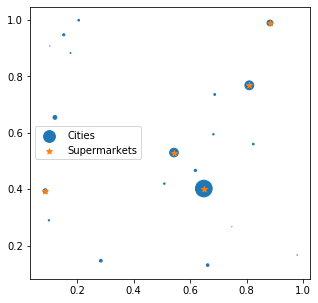

In [8]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# package imports
import time
import math
import random
import itertools
import cma
import pyswarms as ps
import pandas as pd
from tqdm import tqdm
from pyswarms.utils.search.grid_search import GridSearch
from pyswarms.single.global_best import GlobalBestPSO

c = np.genfromtxt("supermarket_city_locations.csv")
p = np.genfromtxt("supermarket_city_populations.csv")
ncities = len(c)
nsupermarkets = 5

# common parameters
maxits = 20000
reps = 5

# Initialising the data frame experiment to save results for each experiment
columns = ["Algorithm", "popsize", "w", "Φg", "Φp", "min", "mean", "stddev", "time", "min_solution"]
experiment = pd.DataFrame(columns=columns)

# running random search
run_random_search()
# running cma
run_CMA()
# running pso
run_PSO()
# displaying results
display_results()


## Results & Conclusions:

> - From the above results, it can be seen that PSO with 100 swarms, inertia 0.4, and both control parameters cp & cg set to 2 give the best solution with cost 150284, meaning the exploitative version of PSO is working best for this optimisation problem.
> - The best results for Random Search (151122) and CMA (152667) are close, however the mean is much better for Random Search than CMA. 
> - Both algorithms seem to be performing better than most configurations of PSO. 
> - However, from standard deviation it can be seen that the solutions over the 5 runs are quite dispersed for these two algorithms.


## Acknowledgements:
> Following resources were used to perform research for above task:

>1. CT5141 - Lecture 05 Slides
>2. https://pypi.org/project/cma/ accessed on 14/11/2021, 10:15
>3. http://www.cmap.polytechnique.fr/~nikolaus.hansen/html-pythoncma/cma.CMAEvolutionStrategy-class.html accessed on 14/11/2021, 10:20
>4. https://en.wikipedia.org/wiki/Random_search accessed on 14/11/2021, 11:00
>5. https://pythonhosted.org/pyswarm/ accessed on 14/11/2021, 12:21
>6. https://pyswarms.readthedocs.io/en/latest/api/pyswarms.single.html#module-pyswarms.single.global_best accessed on 14/11/2021, 12:40
>7. http://www.cmap.polytechnique.fr/~nikolaus.hansen/html-pythoncma/frames.html accessed on 14/11/2021, 15:11
>8. https://www.sciencedirect.com/science/article/pii/S2210650220303710 accessed on 14/11/2021, 15:50
>9. http://ncra.ucd.ie/COMP30290/crc2006/rodgers.pdf accessed on 14/11/2021, 15:55
>10. https://github.com/jerrytheo/psopy accessed on 14/11/2021, 17:29
>11. https://doepy.readthedocs.io/en/latest/ accessed on 15/11/2021, 15:03
>12. https://www.intechopen.com/chapters/69586 accessed on 15/11/2021, 15:31
>13. https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/ accessed on 15/11/2021, 19:44
>14. https://pyswarms.readthedocs.io/en/latest/_modules/pyswarms/utils/search/grid_search.html accessed on 16/11/2021, 19:31
>15. https://pandas.pydata.org/docs/reference/api/pandas.Series.item.html accessed on 17/11/2021, 21:10